# Propósito

Este notebook tem como objetivo realizar uma análise exploratória de algumas colunas de interesse das medições dos sensores de qualidade do ar.

O principal objetivo será preencher alguns valores nulos utilizando a função interpolate()

Mas para não enviesar muitos dados preencheremos apenas os valores em que a quantidade de valores nulas no dia semana menor que 7


# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, anderson, boxcox, kstest, norm
from scipy.special import boxcox1p
from scipy import stats

# Consumindo bases

In [2]:
url_sensor = '/content/drive/MyDrive/TCC/sensores-2011-2021/medicao-sensores.csv'

df_sensor = pd.read_csv(url_sensor, sep=',')

url_estacoes = '/content/drive/MyDrive/TCC/sensores-2011-2021/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

In [3]:
df_sensor.columns

Index(['objectid', 'data', 'codnum', 'estação', 'chuva', 'pres', 'rs', 'temp',
       'ur', 'dir_vento', 'vel_vento', 'so2', 'no2', 'hcnm', 'hct', 'ch4',
       'co', 'no', 'nox', 'o3', 'pm10', 'pm2_5', 'lat', 'lon',
       'x_utm_sirgas2000', 'y_utm_sirgas2000'],
      dtype='object')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

<ipython-input-6-f9a423e0dd73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
<ipython-input-6-f9a423e0dd73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
<ipython-input-6-f9a423e0dd73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[(df_sensor_interest['ano'] > 2011) & (df_sensor_interest['ano'] < 2020)]

In [8]:
#@title Filtrando por Irajá
df_sensor_iraja = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO IRAJÁ']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação Irajá
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10, PM2.5

### Chuva

In [9]:
df_sensor_iraja['chuva'].describe()

,chuva
count,68561.000000
mean,0.134228
std,1.238610
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,88.000000


In [10]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 390


In [11]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['chuva_nulos_no_dia'] = (
    df_sensor_iraja['chuva'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-11-cc821bbf18b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['chuva_nulos_no_dia'] = (


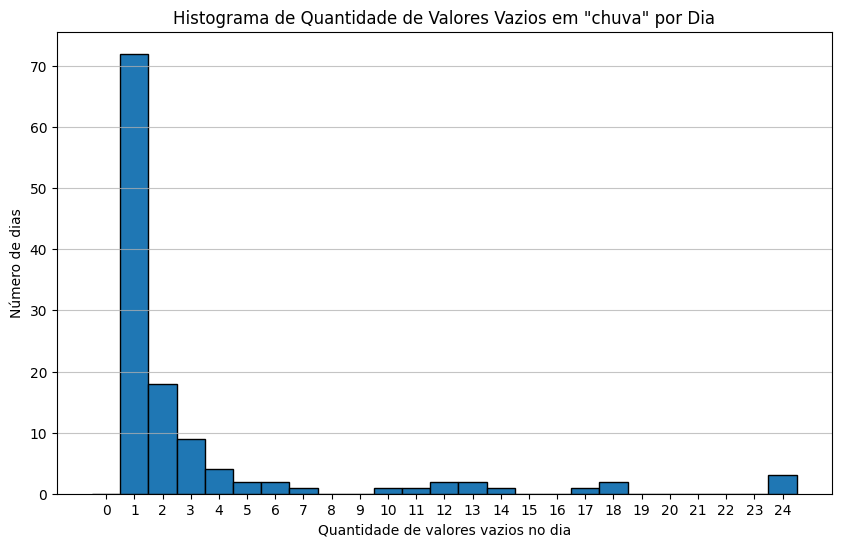

In [12]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_iraja['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['chuva'].isnull().sum()
df_sensor_iraja.loc[mask, 'chuva'] = df_sensor_iraja[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

173 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 44% de dados


In [14]:
df_sensor_iraja['chuva'].describe()

,chuva
count,68734.000000
mean,0.134840
std,1.238861
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,88.000000


### Temperatura

In [15]:
df_sensor_iraja['temp'].describe()

,temp
count,59114.000000
mean,27.439119
std,4.889536
min,14.600000
25%,23.840000
50%,26.730000
75%,30.370000
max,45.650000


In [16]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 9837


In [17]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['temp_nulos_no_dia'] = (
    df_sensor_iraja['temp'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-17-f0c0cd3fb7ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['temp_nulos_no_dia'] = (


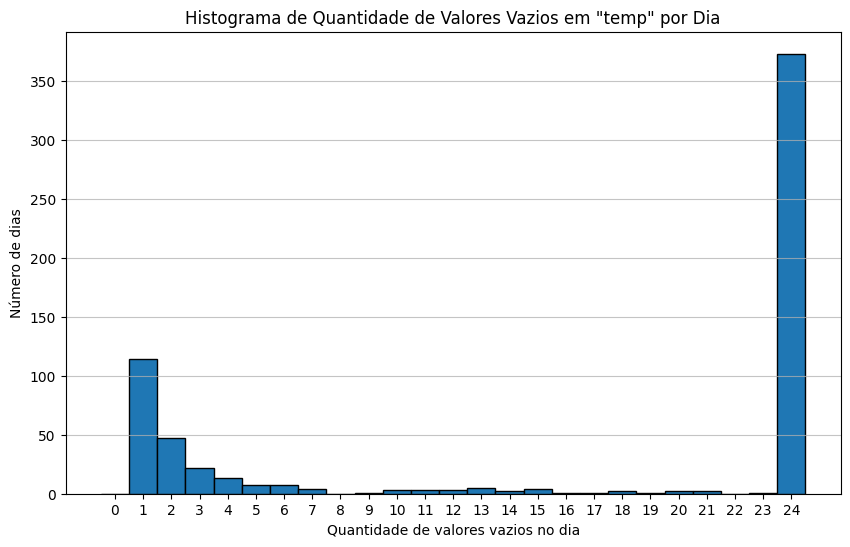

In [18]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['temp'].isnull().sum()
df_sensor_iraja.loc[mask, 'temp'] = df_sensor_iraja[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

403 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 4% de dados


In [20]:
df_sensor_iraja['temp'].describe()

,temp
count,59517.000000
mean,27.448163
std,4.890991
min,14.600000
25%,23.850000
50%,26.750000
75%,30.380000
max,45.650000


### Umidade relativa

In [21]:
df_sensor_iraja['ur'].describe()

,ur
count,52624.000000
mean,66.486515
std,17.907865
min,0.000000
25%,53.700000
50%,68.705000
75%,80.180000
max,100.000000


In [22]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 16327


In [23]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['ur_nulos_no_dia'] = (
    df_sensor_iraja['ur'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-23-a7ebec8e3bb5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['ur_nulos_no_dia'] = (


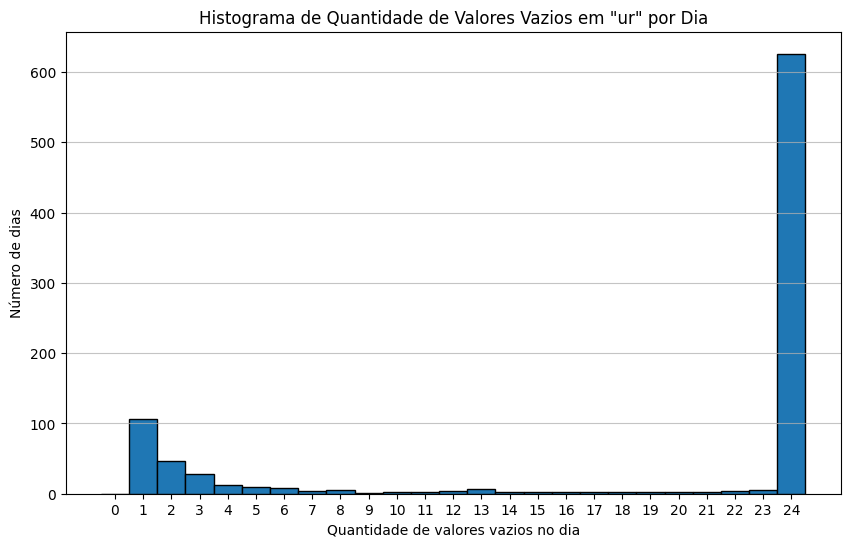

In [24]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [25]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['ur'].isnull().sum()
df_sensor_iraja.loc[mask, 'ur'] = df_sensor_iraja[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

435 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 3% de dados


In [26]:
df_sensor_iraja['ur'].describe()

,ur
count,53059.000000
mean,66.469497
std,17.923644
min,0.000000
25%,53.630000
50%,68.670000
75%,80.180000
max,100.000000


### Monóxido de carbono

In [27]:
df_sensor_iraja['co'].describe()

,co
count,66427.000000
mean,0.441638
std,0.291512
min,0.000000
25%,0.270000
50%,0.380000
75%,0.530000
max,4.620000


In [28]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 2524


In [29]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['co_nulos_no_dia'] = (
    df_sensor_iraja['co'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-29-80707c7deeea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['co_nulos_no_dia'] = (


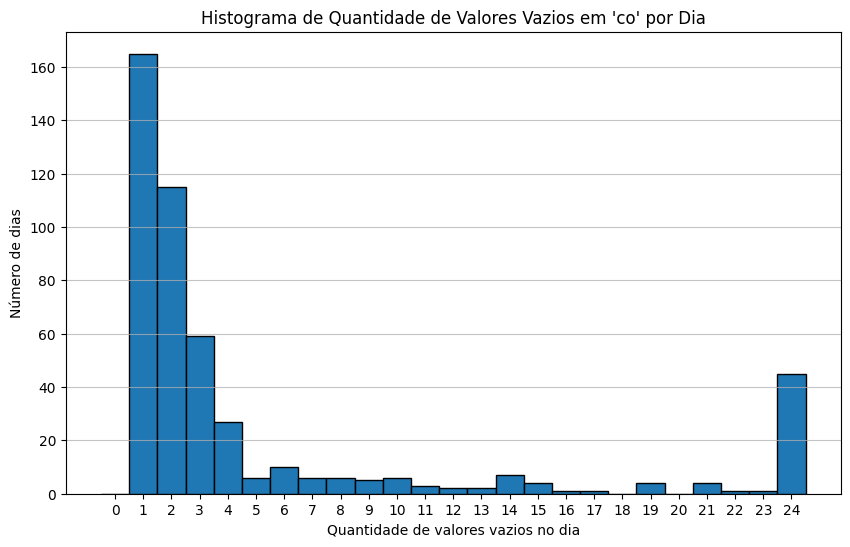

In [30]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [31]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['co'].isnull().sum()
df_sensor_iraja.loc[mask, 'co'] = df_sensor_iraja[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

770 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 31% de dados


In [32]:
df_sensor_iraja['co'].describe()

,co
count,67197.000000
mean,0.442026
std,0.291406
min,0.000000
25%,0.270000
50%,0.390000
75%,0.530000
max,4.620000


### Monóxido de Nitrogênio

In [33]:
df_sensor_iraja['no'].describe()

,no
count,64587.000000
mean,18.834707
std,34.859103
min,0.000000
25%,3.120000
50%,7.250000
75%,18.530000
max,640.380000


In [34]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['no'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4364


In [35]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['no_nulos_no_dia'] = (
    df_sensor_iraja['no'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-35-7114b3a80705>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['no_nulos_no_dia'] = (


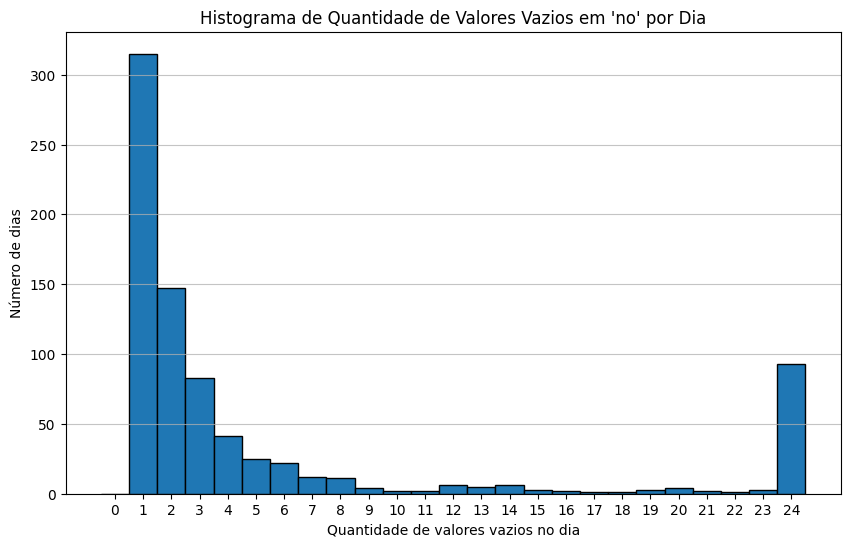

In [36]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['no_nulos_no_dia'] != 0].groupby('data_formatada')['no_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [37]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['no_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['no'].isnull().sum()
df_sensor_iraja.loc[mask, 'no'] = df_sensor_iraja[mask]['no'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1279 linhas foram preenchidas com interpolate na coluna 'no'.
Foram preenchido 29% de dados


In [38]:
df_sensor_iraja['no'].describe()

,no
count,65866.000000
mean,18.744827
std,34.732785
min,0.000000
25%,3.100000
50%,7.240000
75%,18.407500
max,640.380000


### Dióxido de Nitrogênio

In [39]:
df_sensor_iraja['no2'].describe()

,no2
count,64586.000000
mean,41.033458
std,20.491612
min,0.000000
25%,26.380000
50%,37.680000
75%,51.380000
max,211.810000


In [40]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['no2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4365


In [41]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['no2_nulos_no_dia'] = (
    df_sensor_iraja['no2'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-41-375e13fc8d0d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['no2_nulos_no_dia'] = (


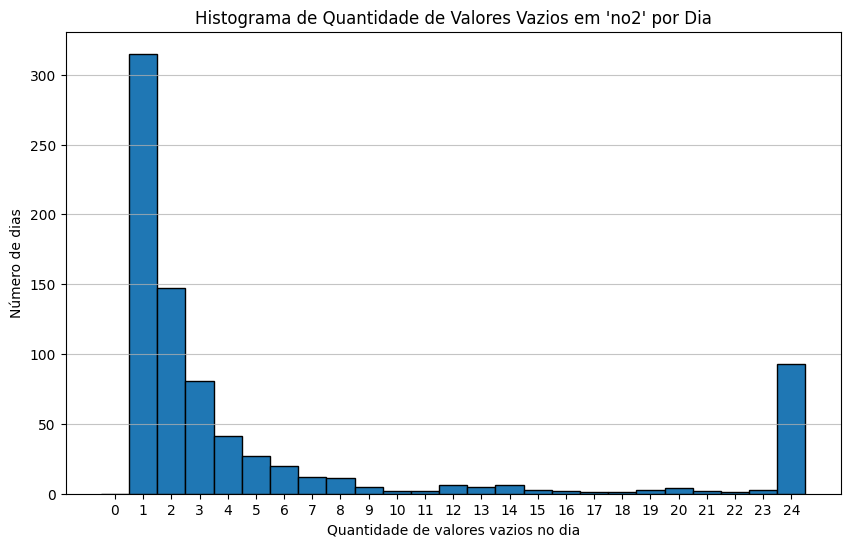

In [42]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['no2_nulos_no_dia'] != 0].groupby('data_formatada')['no2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [43]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['no2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['no2'].isnull().sum()
df_sensor_iraja.loc[mask, 'no2'] = df_sensor_iraja[mask]['no2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1271 linhas foram preenchidas com interpolate na coluna 'no2'.
Foram preenchido 29% de dados


In [44]:
df_sensor_iraja['no2'].describe()

,no2
count,65857.000000
mean,40.982319
std,20.493928
min,0.000000
25%,26.330000
50%,37.620000
75%,51.313333
max,211.810000


### Óxido de Nitrogênio

In [45]:
df_sensor_iraja['nox'].describe()

,nox
count,64582.000000
mean,59.856572
std,47.832084
min,0.000000
25%,31.060000
50%,46.570000
75%,72.190000
max,702.670000


In [46]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['nox'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4369


In [47]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['nox_nulos_no_dia'] = (
    df_sensor_iraja['nox'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-47-5e4feb58038b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['nox_nulos_no_dia'] = (


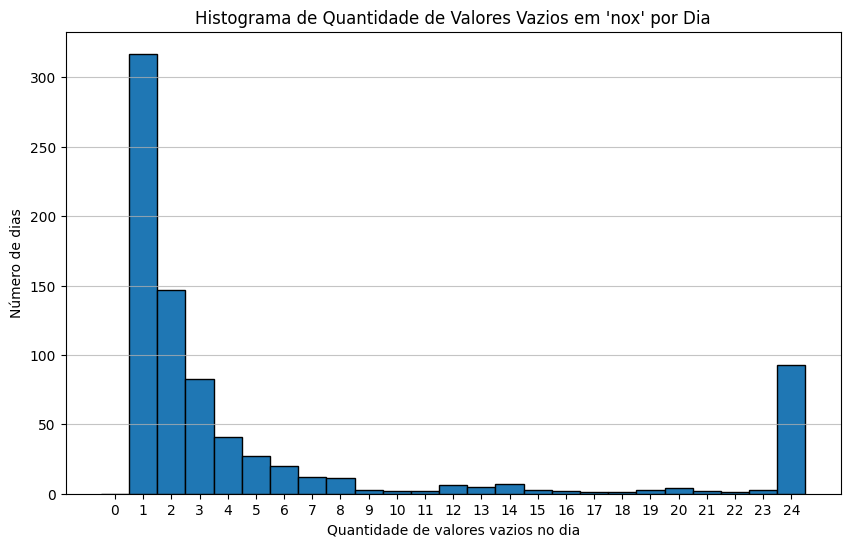

In [48]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['nox_nulos_no_dia'] != 0].groupby('data_formatada')['nox_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'nox' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [49]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['nox_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['nox'].isnull().sum()
df_sensor_iraja.loc[mask, 'nox'] = df_sensor_iraja[mask]['nox'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'nox'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1279 linhas foram preenchidas com interpolate na coluna 'nox'.
Foram preenchido 29% de dados


In [50]:
df_sensor_iraja['nox'].describe()

,nox
count,65861.000000
mean,59.710520
std,47.696563
min,0.000000
25%,31.020000
50%,46.450000
75%,72.030000
max,702.670000


### Dióxido de Enxofre

In [51]:
df_sensor_iraja['so2'].describe()

,so2
count,52634.000000
mean,3.650396
std,6.815725
min,0.000000
25%,0.350000
50%,2.020000
75%,4.450000
max,309.130000


In [52]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 16317


In [53]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['so2_nulos_no_dia'] = (
    df_sensor_iraja['so2'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-53-66fb60ba661a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['so2_nulos_no_dia'] = (


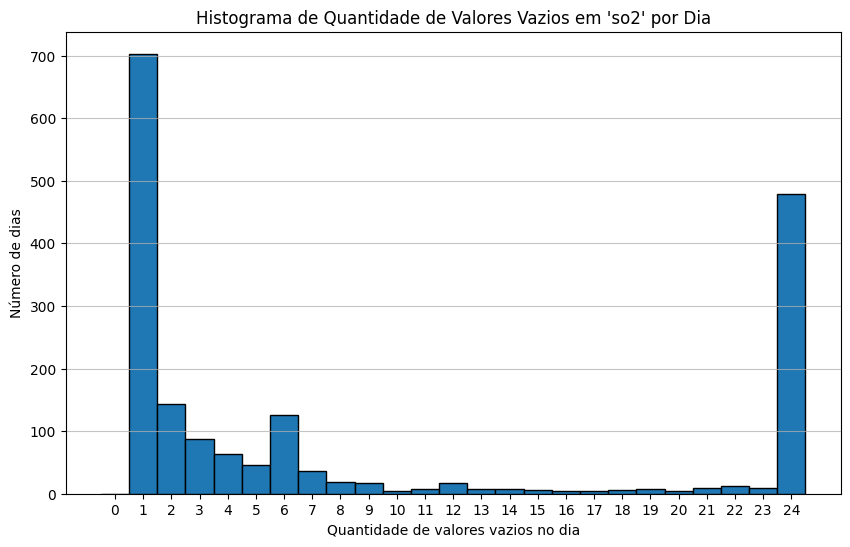

In [54]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [55]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['so2'].isnull().sum()
df_sensor_iraja.loc[mask, 'so2'] = df_sensor_iraja[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2487 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 15% de dados


In [56]:
df_sensor_iraja['so2'].describe()

,so2
count,55121.000000
mean,3.658755
std,6.750929
min,0.000000
25%,0.380000
50%,2.040000
75%,4.460000
max,309.130000


### Ozônio

In [57]:
df_sensor_iraja['o3'].describe()

,o3
count,63028.000000
mean,34.364118
std,33.909193
min,0.000000
25%,8.220000
50%,25.360000
75%,49.500000
max,355.450000


In [58]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 5923


In [59]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['o3_nulos_no_dia'] = (
    df_sensor_iraja['o3'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-59-58004409c095>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['o3_nulos_no_dia'] = (


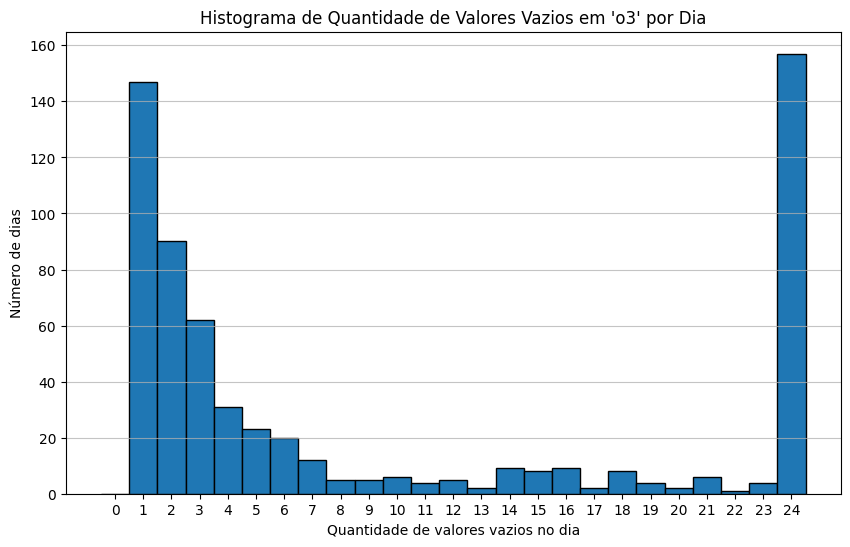

In [60]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [61]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['o3'].isnull().sum()
df_sensor_iraja.loc[mask, 'o3'] = df_sensor_iraja[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

872 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 15% de dados


In [62]:
df_sensor_iraja['o3'].describe()

,o3
count,63900.000000
mean,34.507100
std,33.899389
min,0.000000
25%,8.350000
50%,25.570000
75%,49.710000
max,355.450000


### PM10

In [63]:
df_sensor_iraja['pm10'].describe()

,pm10
count,65902.000000
mean,37.570560
std,24.391653
min,0.000000
25%,22.000000
50%,32.000000
75%,47.000000
max,409.000000


In [64]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 3049


In [65]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['pm10_nulos_no_dia'] = (
    df_sensor_iraja['pm10'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-65-1ccd4a9a5046>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['pm10_nulos_no_dia'] = (


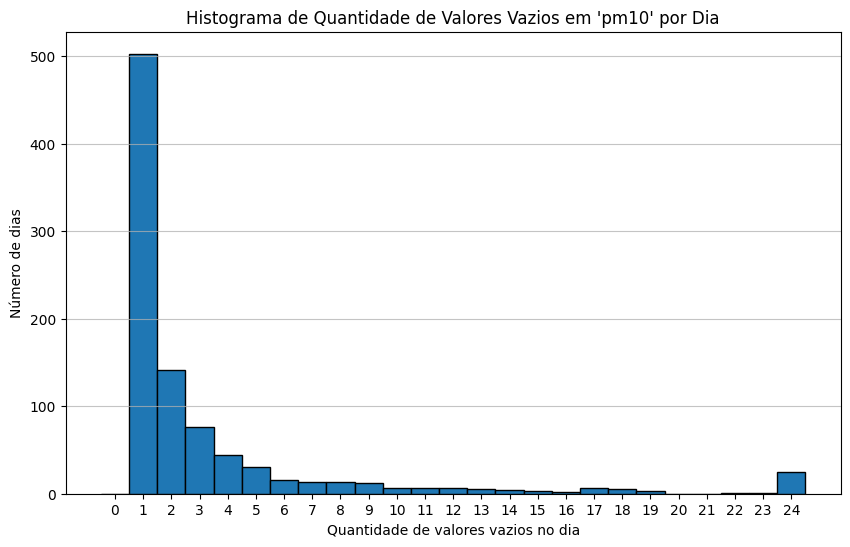

In [66]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [67]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['pm10'].isnull().sum()
df_sensor_iraja.loc[mask, 'pm10'] = df_sensor_iraja[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1435 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 47% de dados


In [68]:
df_sensor_iraja['pm10'].describe()

,pm10
count,67337.000000
mean,37.480222
std,24.401894
min,0.000000
25%,21.670000
50%,32.000000
75%,47.000000
max,409.000000


### PM2.5

In [69]:
df_sensor_iraja['pm2_5'].describe()

,pm2_5
count,62170.000000
mean,17.284460
std,14.793721
min,0.000000
25%,8.000000
50%,13.000000
75%,23.000000
max,370.000000


In [70]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['pm2_5'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 6781


In [71]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['pm2_5_nulos_no_dia'] = (
    df_sensor_iraja['pm2_5'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-71-bd9c5d89174b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['pm2_5_nulos_no_dia'] = (


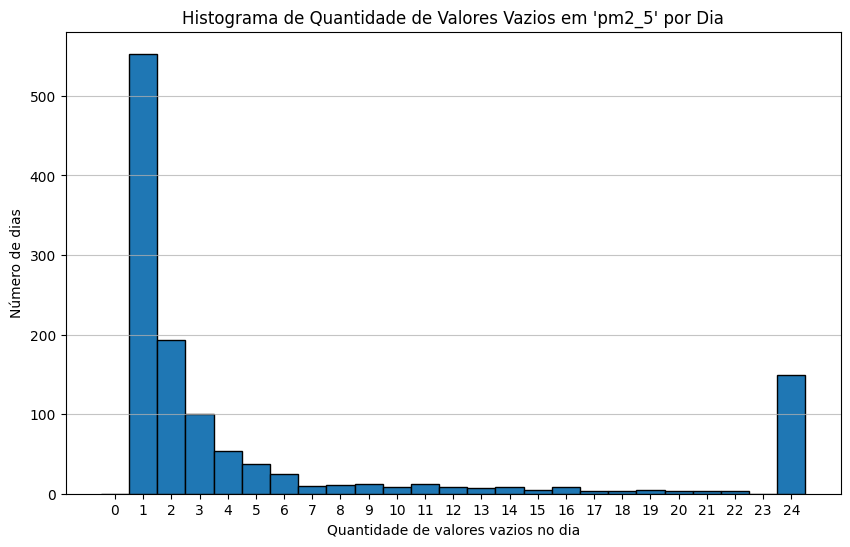

In [72]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['pm2_5_nulos_no_dia'] != 0].groupby('data_formatada')['pm2_5_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm2_5' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [73]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['pm2_5_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['pm2_5'].isnull().sum()
df_sensor_iraja.loc[mask, 'pm2_5'] = df_sensor_iraja[mask]['pm2_5'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm2_5'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1790 linhas foram preenchidas com interpolate na coluna 'pm2_5'.
Foram preenchido 26% de dados


In [74]:
df_sensor_iraja['pm2_5'].describe()

,pm2_5
count,63960.000000
mean,17.222891
std,14.762144
min,0.000000
25%,8.000000
50%,13.000000
75%,22.000000
max,370.000000


# Gerando CSV de saída com a estação de Campo Grande preenchida


In [75]:
droping_columns = ['chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'co_nulos_no_dia', 'no_nulos_no_dia', 'no2_nulos_no_dia', 'nox_nulos_no_dia', 'so2_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia', 'pm2_5_nulos_no_dia']

df_sensor_iraja.drop(columns=droping_columns, inplace=True)

<ipython-input-75-f0c2848c79d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja.drop(columns=droping_columns, inplace=True)


In [76]:
df_sensor_iraja.to_csv('df_sensor_iraja_preenchido.csv', index=False)